In [12]:
import os
from pyprojroot import here
os.environ["HF_HOME"] = str(here("cache/huggingface"))
import lightning as L
from importlib import reload
import sys
sys.path.append(str(here()))
from models import model_definitions as MD
import torch
import pandas as pd
reload(MD)
torch.set_float32_matmul_precision('medium')
data_module_3 = MD.GoEmotionsDataModule(pd.read_parquet(here("data/goemotions_3.parquet")))
data_module_7 = MD.GoEmotionsDataModule(pd.read_parquet(here("data/goemotions_7.parquet")))
data_module_28 = MD.GoEmotionsDataModule(pd.read_parquet(here("data/goemotions_28.parquet")))
metrics = MD.MetricsCallback()

trainer = L.Trainer(
  max_epochs=15,
  max_time={"minutes": 10},
  callbacks=[
    metrics,
  ],
  deterministic=True,
  default_root_dir=here("cache/lightning"),
  enable_checkpointing=True,
  fast_dev_run=False,
  accelerator="auto", 
)
trainer

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
reload(MD)
distil_3 = MD.DistilBertFinetune(n_emotions=3)
if False:    
  trainer.fit(
    distil_3,
    datamodule=data_module_3,
  )
else:
  distil_3 = MD.DistilBertFinetune.load_from_checkpoint(
    here("models/model_checkpoints/distil_bert_finetuned_3.ckpt"),
    n_emotions=3,
  )
out = trainer.test(
  distil_3,
  datamodule=data_module_3,
)
del distil_3
out

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Plancha\emotion-recognition\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.5899204015731812
        test_loss           0.47713154554367065
        test_rmse           0.25546500086784363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.47713154554367065,
  'test_f1': 0.5899204015731812,
  'test_rmse': 0.25546500086784363}]

In [3]:
reload(MD)
distil_7 = MD.DistilBertFinetune(n_emotions=7)
if False:    
  trainer.fit(
    distil_7,
    data_module=data_module_7,
  )
else:
  distil_7 = MD.DistilBertFinetune.load_from_checkpoint(
    here("models/model_checkpoints/distil_bert_finetuned_7.ckpt"),
    n_emotions=7,
  )
out = trainer.test(
  distil_7,
  datamodule=data_module_7
)
del distil_7
out

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Plancha\emotion-recognition\.pixi\envs\gpu\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.23050302267074585
        test_loss           0.2821902334690094
        test_rmse           0.18872764706611633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2821902334690094,
  'test_f1': 0.23050302267074585,
  'test_rmse': 0.18872764706611633}]

In [ ]:
reload(MD)
distil_28 = MD.DistilBertFinetune(n_emotions=28)
if False:    
  trainer.fit(
    distil_28,
    datamodule=data_module_28,
  )
else:
  distil_28 = MD.DistilBertFinetune.load_from_checkpoint(
    here("models/model_checkpoints/distil_bert_finetuned_28.ckpt"),
    n_emotions=28,
  )
out = trainer.test(
  distil_28,
  datamodule=data_module_28,
)
del distil_28
out

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params | Mode 
-------------------------------------------------------------------------
0 | model    | DistilBertForSequenceClassification | 67.0 M | train
1 | sigmoid  | Sigmoid                             | 0      | train
2 | sig_loss | BCEWithLogitsLoss                   | 0      | train
3 | f1       | MultilabelF1Score                   | 0      | train
4 | rmse     | MeanSquaredError                    | 0      | train
-------------------------------------------------------------------------
612 K     Trainable params
66.4 M    Non-trainab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Time limit reached. Elapsed time is 0:10:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.08509474992752075
        test_loss            0.117050901055336
        test_rmse           0.11105237901210785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.117050901055336,
  'test_f1': 0.08509474992752075,
  'test_rmse': 0.11105237901210785}]

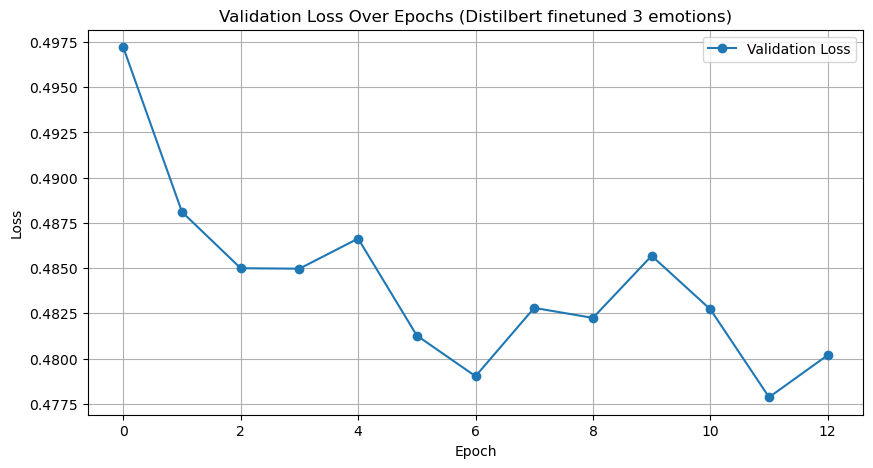

In [9]:
# plot loss without the first observation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(metrics.epochs[1:], metrics.val_losses[1:], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs (Distilbert finetuned 3 emotions)')
plt.legend()
plt.grid()
plt.show()

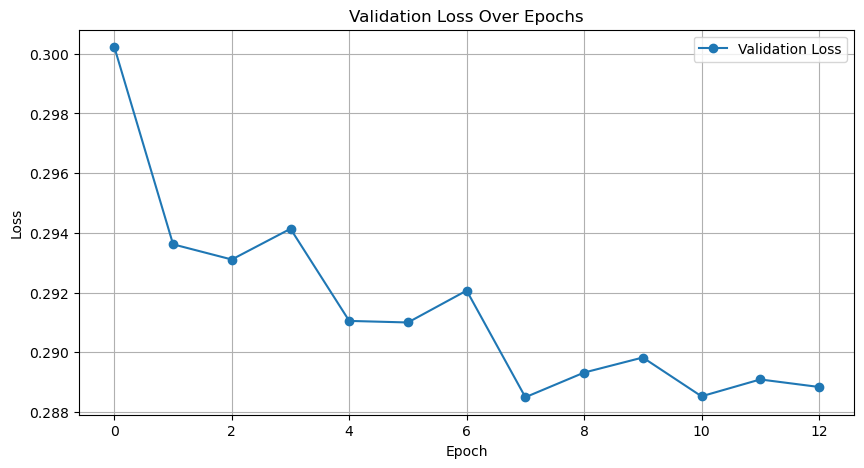

In [ ]:
# finetuned 7 emotions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(metrics.epochs[1:], metrics.val_losses[1:], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

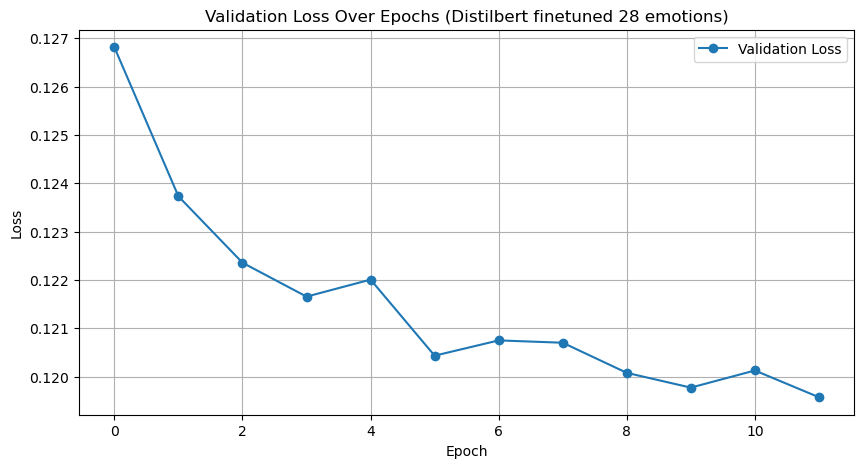

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(metrics.epochs[1:], metrics.val_losses[1:], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs (Distilbert finetuned 28 emotions)')
plt.legend()
plt.grid()
plt.show()